# Zaitsev Anton | Exercise 5

## General Information

In this exercise we will further analyze the Facebook network (**Group 8**). Namely, we will:
1. Explore the types of subgraphs in the network.
2. Define 3 community detection algorithms.
3. Detect communities in the network and plot them.
4. Identify the differences between community detection results.

In [1]:
# need to install leidenalg package which implements Leiden algorithm
# leidenalg only supports igraph graphs, so we also install igraph package
!pip install leidenalg
!pip install igraph


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# imports
import networkx as nx
import leidenalg
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.spatial import ConvexHull

In [3]:
# global variables
DATA_FOLDER = "../data/"

In [4]:
# utilities
def construct_graph(edges_path: str, directed: bool = False) -> nx.Graph:
    """
    Construct a graph from an edge list.

    Parameters:
        - edges_path (str): The path to the .edges file, which contains the edges of the graph.
        - directed (bool): If True, the graph will be treated as directed, creating a NetworkX DiGraph.
    
    Returns:
        - g (nx.Graph or nx.DiGraph): A NetworkX graph containing all the nodes and edges from the .edges file.
                                      Additionally, nodes present in the .feat file but missing in the .edges
                                      file will be added to the graph as disconnected nodes (without any edges).
    """
    # read graph from .edges file
    if directed:
        g = nx.read_edgelist(edges_path, create_using=nx.DiGraph(), nodetype=int)
    else:
        g = nx.read_edgelist(edges_path, create_using=nx.Graph(), nodetype=int)
    return g

In [5]:
# load facebook network, indirected graph
G_fb = construct_graph(edges_path=f"{DATA_FOLDER}3437.edges", directed=False)

## Question **a**

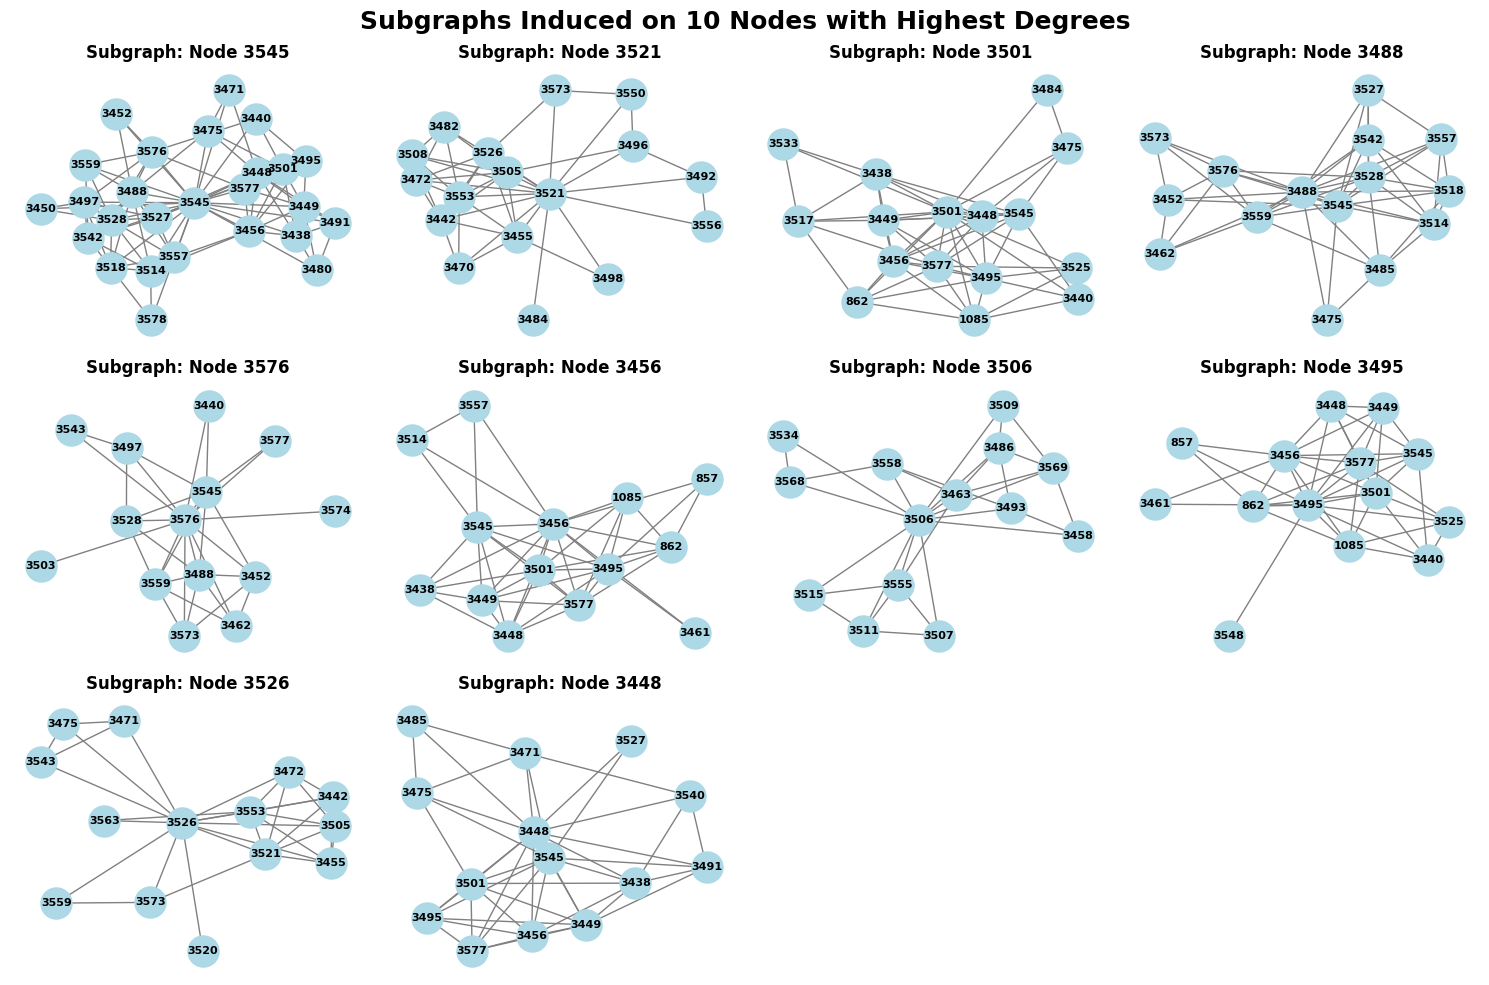

In [6]:
# step 1: choose 10 nodes in the graph that have the highest degrees
# get degree dictionary
degree_dict = dict(G_fb.degree())
# get top-10 nodes in terms of degrees
top_10_nodes_degrees = sorted(degree_dict, key=degree_dict.get, reverse=True)[:10]

# step 2: for each node induce a subgraph of that node and its neighbors
subgraphs = {}
for node in top_10_nodes_degrees:
    # induce a subgraph on the node and its neighbors
    neighbors = list(G_fb.neighbors(node)) + [node]
    subgraphs[node] = G_fb.subgraph(neighbors)

# step 3: plot all subgraphs
plt.figure(figsize=(15, 10))
for i, (node, subgraph) in enumerate(subgraphs.items(), 1):
    plt.subplot(3, 4, i)
    nx.draw(subgraph, with_labels=True, node_color="lightblue", node_size=500, font_size=8, font_weight="bold", edge_color="gray")
    plt.title(f"Subgraph: Node {node}", fontsize=12, fontweight="bold")
plt.suptitle(f"Subgraphs Induced on 10 Nodes with Highest Degrees", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()

## Question **b**

There are many algorithms used for community/clusters detection. Some of them are:

### **Divisive Hierarchical Clustering**

Divisive hierarchical clustering: based on edge betweenness.
1. Compute betweenness for all edges in the network.
   - **Edge Betweenness**: The betweenness of an edge is the number
   of shortest-paths in the network that pass through that edge.
   - *Bridges* between communities have high edge betweenness.
2. Remove the edge with highest betweenness.
3. Go to step 1 until no edges left.

### **Louvain Algorithm**

Louvain algorithm: greedily maximises modularity.

1. **Phase 1**:
   1.  Assign a different community to each node.
   2.  For each node $i$:
       1. Compute the modularity gain ($\nabla Q$) when putting node $i$ into the community of some neighbour $j$.
       2. Move $i$ to a community of node $j$ that yields the largest modularity gain $\nabla Q$
       3. If no increase is possible, $i$ remains in its original community.
    3. Repeat until no movement yields a modularity gain.
2. **Phase 2**:
   1. Each partition $c_i$ obtained in **Phase 1** forms a new super-node $i$ (a self-loop with weight corresponds to the intra-community weight).
   2. Super-nodes $i$ and $j$ are connected if there is at least one edge betwee nodes of their corresponding partitions ($c_i$ and $c_j$)
   3. The weight of the edge between new super-nodes $i$ and $j$ is the sum of weights from all edges between their corresponding partitions ($c_i$ and $c_j$).
3. **Phase 3**: 
    1.  Apply the Leiden algorithm to the new graph of super-nodes.
    2.  Repeat **Phase 1** and **Phase 2** for the new graph until the communities stabilize, and no further modularity gains are possible.

### **Leiden Algorithm**

Leiden algorithm: improvement on the **Louvain algorithm**, addressing some of Louvain’s issues with disconnected communities.

1. **Phase 1**: same as Louvain algorithm, but after moving all nodes, **refine** each community to ensure it's connected:
   - If a community splits into multiple disconnected parts, treat each disconnected sub-community as a new community.
   - This guarantees that all resulting communities are internally connected.
2. **Phase 2**:
   1. After Phase 1, examine the connectivity within each community.
      - If a community consists of multiple disconnected sub-communities, split the community into those sub-communities.
   2. Like in the Louvain algorithm, after refining the communities, aggregate nodes that belong to the same community into a **super-node**.
3.  **Phase 3**: same as in Louvain algorithm.

## Question **c**

Here we will detect the communities in the *Facebook* network using **Divisive Hierarchical**, **Louvain** and **Leiden** algorithms and plot the communities.

In [7]:
def draw_convex_hull(points, ax, color):
    # only draw convex hull if there are 3 or more points
    if len(points) >= 3:
        hull = ConvexHull(points)
        hull_points = points[hull.vertices, :]
        poly = plt.Polygon(hull_points, alpha=0.2, edgecolor=color, facecolor=color)
        ax.add_patch(poly)
    # for 2 nodes, draw a simple line or ellipse
    elif len(points) == 2:
        ax.plot(points[:, 0], points[:, 1], color=color, alpha=0.5, lw=3)

def plot_communities_in_subplot(ax, graph, communities, title, k_value, cmap_name="viridis"):
    pos = nx.spring_layout(graph, k=k_value)
    legend_handles = []
    cmap = plt.get_cmap(cmap_name)
    for i, community in enumerate(communities):
        # color and label for each community
        color = cmap(i / len(communities))
        label = f"Community {i + 1}"
        # draw convex hull around the community nodes
        community_pos = np.array([pos[node] for node in community])
        draw_convex_hull(community_pos, ax, color=color)
        # draw the community nodes
        nx.draw_networkx_nodes(
            graph, pos, nodelist=community, 
            node_color=[color], 
            node_size=500, alpha=0.65, ax=ax
        )
        legend_handles.append(mpatches.Patch(color=color, label=label))
    nx.draw_networkx_edges(graph, pos, alpha=0.5, ax=ax)
    ax.legend(handles=legend_handles, loc="best", title="Communities", fontsize=7)
    ax.set_title(title, fontsize=14, fontweight="bold")

In [8]:
def find_girvan_newman_communities(graph: nx.Graph):
    """
    Divisive Hierarchical (Girvan-Newman) algorithm for finding communities in the graph.
    """
    communities = nx.community.girvan_newman(graph)
    return list(sorted(c) for c in next(communities))

def find_louvain_communities(graph: nx.Graph):
    """
    Louvain algorithm for finding communities in the graph.
    """
    communities = nx.community.louvain_communities(graph)
    return communities

def find_leiden_communities(graph):
    """
    Leiden algorithm for finding communities in the graph.
    """
    # step 1: convert the NetworkX graph to an iGraph graph

    # NOTE: ig.Graph.from_networkx() uses sequential integer indices for nodes, starting from 0. 
    #       when we convert a NetworkX graph to iGraph, it internally reassigns the node labels to 0-based indices.
    #       thus, we need to create a map from actual node numbers in G_fb to reassigned node numbers

    # create a mapping from node labels to node indices
    node_mapping = {node: i for i, node in enumerate(graph.nodes())}
    # reverse mapping for later
    reverse_mapping = {i: node for node, i in node_mapping.items()} 
    # convert the NetworkX graph to an iGraph graph
    g_igraph = ig.Graph.from_networkx(graph)
    # step 2: run the Leiden algorithm to detect communities
    partition = leidenalg.find_partition(g_igraph, leidenalg.ModularityVertexPartition)
    # step 3: convert iGraph community nodes back to the original NetworkX labels
    communities = [[reverse_mapping[node] for node in community] for community in partition]
    return communities

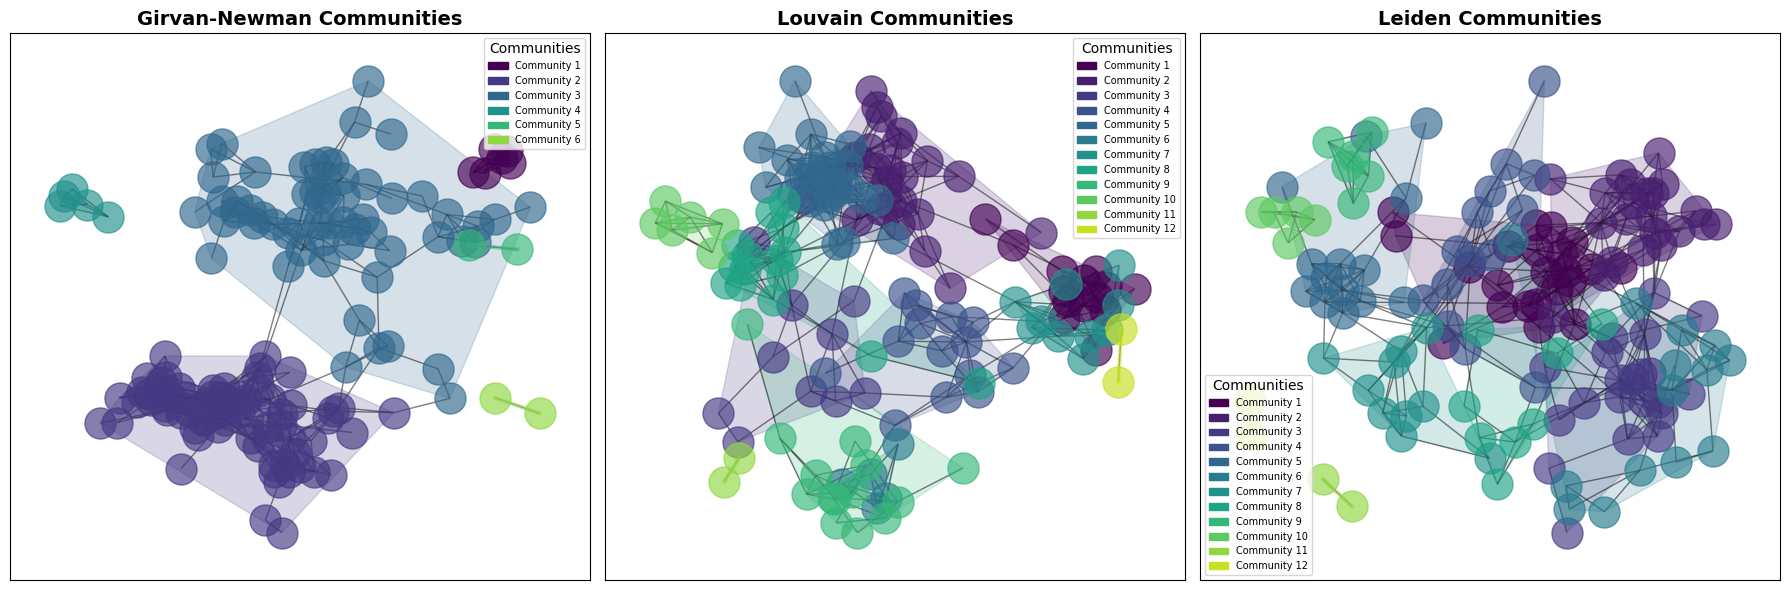

In [9]:
# compute the communities using specified algorithms
gn_communities = find_girvan_newman_communities(graph=G_fb)
lou_communities = find_louvain_communities(graph=G_fb)
lei_communities = find_leiden_communities(graph=G_fb)
# plot all the communities results in a single plot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_communities_in_subplot(axes[0], G_fb, gn_communities, "Girvan-Newman Communities", k_value=0.2)
plot_communities_in_subplot(axes[1], G_fb, lou_communities, "Louvain Communities", k_value=0.3)
plot_communities_in_subplot(axes[2], G_fb, lei_communities, "Leiden Communities", k_value=0.3)
plt.tight_layout()
plt.show()

In [14]:
def printCommunitySizes(algos_communities: list, titles: list) -> None:
    for algo_communities, title in zip(algos_communities, titles):
        print(f"{title} community sizes:")
        sorted_algo_communities = sorted(algo_communities, key=len, reverse=True)
        for i, community in enumerate(sorted_algo_communities):
            print(f"    Community {i}, size: {len(community)}")
printCommunitySizes([gn_communities, lou_communities, lei_communities], ["Givan-Newman", "Louvain", "Leiden"])

Givan-Newman community sizes:
    Community 0, size: 67
    Community 1, size: 58
    Community 2, size: 6
    Community 3, size: 5
    Community 4, size: 2
    Community 5, size: 2
Louvain community sizes:
    Community 0, size: 25
    Community 1, size: 23
    Community 2, size: 15
    Community 3, size: 14
    Community 4, size: 14
    Community 5, size: 14
    Community 6, size: 10
    Community 7, size: 10
    Community 8, size: 6
    Community 9, size: 5
    Community 10, size: 2
    Community 11, size: 2
Leiden community sizes:
    Community 0, size: 22
    Community 1, size: 22
    Community 2, size: 21
    Community 3, size: 14
    Community 4, size: 14
    Community 5, size: 14
    Community 6, size: 10
    Community 7, size: 8
    Community 8, size: 6
    Community 9, size: 5
    Community 10, size: 2
    Community 11, size: 2


## Question **d**

The differences between the community detection results we are going to discuss are the number of communities detected and the community sizes. 

We can see a clear difference in how communities are detected in the Girvan-Newman algorithm compared to the Louvain and Leiden algorithms. The Girvan-Newman algorithm detects only $6$ communities, with $2$ significantly larger communities (sizes $67$ and $58$) compared to the other $4$ smaller ones (sizes $6, 5, 2, 2$). The reason for this difference lies in the splitting criteria between the algorithms:

1. **Girvan-Newman** is an edge-betweenness-based algorithm, which gradually removes the edges that are most "between" communities, typically leading to the detection of a **few larger communities** and several much smaller ones. This algorithm focuses on topological "bottlenecks" within the network, which leads to a more hierarchical and less granular community structure.

2. On the other hand, **Louvain and Leiden** algorithms focus on maximizing modularity, a measure that favors denser intra-community links while minimizing inter-community links. Both algorithms begin by partitioning the network into small communities and then iteratively refining them to optimize modularity. This results in a **larger number of smaller, more balanced community sizes** compared to Girvan-Newman.

Finally, the Leiden algorithm produces results that are similar to the Louvain algorithm but with a slight improvement. It detects $12$ communities compared to Louvain's $11$. This is expected because **Leiden** improves on Louvain by allowing communities to **split into disconnected subcommunities**, addressing one of the limitations of Louvain. As a result, Leiden identifies slightly finer-grained community structures, which explains the additional community it detects in this case.